In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
base_model = MobileNetV2(include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

input_tensor = tf.keras.Input(shape=(32, 32, 3))
x = layers.UpSampling2D((3,3))(input_tensor)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [3]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [5]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [23]:
batch_size = 64
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/30


NotImplementedError: numpy() is only available when eager execution is enabled.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

✅ Final Test Accuracy: 89.38%


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


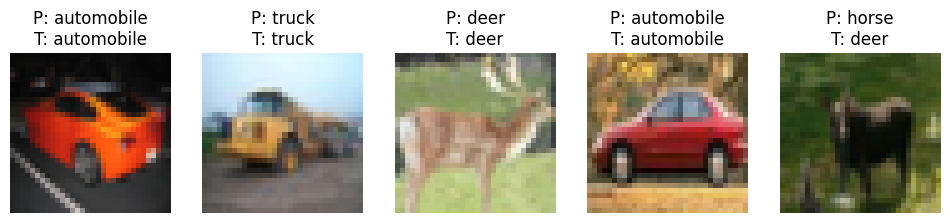

In [15]:
import random
idx = random.sample(range(len(x_test)), 5)
images, labels = x_test[idx], y_test[idx]
preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.title(f"P: {class_names[pred_classes[i]]}\nT: {class_names[true_classes[i]]}")
    plt.axis("off")
plt.show()

In [16]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

In [17]:
model = load_model("best_model.h5")

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [18]:
def predict(img):
    img = img.resize((32,32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = float(np.max(preds))
    return {pred_class: confidence}

In [24]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="CIFAR-10 Image Classifier",
    description="uplod any photo from cars, airplans, truks"
)
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b898d67e712ab8c82d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
